# Notebook 452: MESA wind checks 2

In this notebook we check whether MESA is overriding `other_wind` or if there is an issue with the rotational boost to the winds.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 452

## Imports & Definitions

#### Imports

In [2]:
import sys
from pathlib import Path

import numpy as np
import mesa_reader as mr
import mesaPlot as mp
import astropy.constants as ct
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

sys.path.append('..')
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

#### Constants

Set the grid to be loaded in `PROJECT_FOLDER`.

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

PROJECT_FOLDER = DATA_ROOT/'sse_test3_fiducial_dbg'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
Z_SUN = 0.014

In [5]:
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)
      
def get_model_folder(*args, **kwargs):
    return get_model_folder_base(PROJECT_FOLDER, *args, **kwargs)

#### Wind definitions

In [6]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def vink2001_w(l, m, teff, z):
    teff_jump = 61.2 + 2.59*(-13.636+0.889*np.log10(z/Z_SUN))
    dteff_jump = 100
    
    if teff > 27.5e3:
        a = 1
    elif teff < 22.5e3:
        a = 0
    else:
        if teff > teff_jump+dteff_jump:
            a = 1
        elif teff < teff_jump-dteff_jump:
            a = 0
        else:
            a = (teff-(teff_jump-dteff_jump))/(2*dteff_jump)
    
    if a > 0:
        vinf_div_vesc = 2.6*(z/Z_SUN)**0.13
        log_mdot = (-6.697
                    +2.194*np.log10(l/1e5)
                    -1.313*np.log10(m/30)
                    -1.226*np.log10(vinf_div_vesc/2)
                    +0.933*np.log10(teff/4e4)
                    -10.92*np.log10(teff/4e4)**2
                    +0.85*np.log10(z/Z_SUN))
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
    
    if a < 1:
        vinf_div_vesc = 1.3*(z/Z_SUN)**0.13
        log_mdot = (-6.688
                    +2.210*np.log10(l/1e5)
                    -1.339*np.log10(m/30)
                    -1.601*np.log10(vinf_div_vesc/2)
                    +1.07*np.log10(teff/4e4)
                    +0.85*np.log10(z/Z_SUN))
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0

    w = a*mdot1 + (1-a)*mdot2
    return w

def bjorklund2021_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def krticka2018_w(l, z):
    log_mdot = (-5.7
                +0.5*np.log10(z/Z_SUN)
                +(1.61 - 0.12*np.log10(z/Z_SUN)) * np.log10(l/1e6)
                )
    w = 10.**log_mdot
    return w

def sabhahit2023_switch_g(z):
    l = sabhahit2023_switch_l(z)
    m = sabhahit2023_switch_m(z)
    return 2.5e-5 * l/m

def sabhahit2023_switch_l(z):
    return 10.**2.36 * z**-1.91

def sabhahit2023_switch_m(z):
    return 0.0615 * z**-1.574 + 18.1

def vink2011_w(l, m, z):
    logmdot_switch = -1.86*np.log10(z) - 8.9
    l_switch = sabhahit2023_switch_l(z)
    m_switch = sabhahit2023_switch_m(z)
    w = 10.**logmdot_switch * (l/l_switch)**4.77 * (m/m_switch)**-3.99
    return w

def sabhahit2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    g_e_switch = sabhahit2023_switch_g(z)
    dg_e = 0.01
    
    if g_e > g_e_switch+dg_e:
        a = 1
    elif g_e < g_e_switch-dg_e:
        a = 0
    else:
        a = (g_e-(g_e_switch-dg_e))/(2*dg_e) 
    
    if a > 0:
        w1 = vink2011_w(l, m, z)
    else:
        w1 = 0
    
    if a < 1:
        w2 = bjorklund2021_w(l, m, teff, z, x)
    else:
        w2 = 0
        
    w = a*w1 + (1-a)*w2
    return w
sabhahit2023_w = np.vectorize(sabhahit2023_w)

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2020_w(g_e, z):
    g_eb = -0.324*np.log10(z/Z_SUN) + 0.244
    c = -0.44*np.log10(z/Z_SUN) + 9.15
    d = 0.23*np.log10(z/Z_SUN) - 2.61
    
    #print(g_eb, c, d, g_e, z)
    
    log_mdot = 2.932 * np.log10(-np.log10(1-g_e)) - np.log10(2) * (g_eb/g_e)**c + d
    #print(2.932 , np.log10(-np.log10(1-g_e)), np.log10(2), (g_eb/g_e), c, d)
    w = 10.**log_mdot
    return w

def sander2023_w(l, m, t_eff, z, x):
    g_e = edd_gamma(x, l, m)
    #print(g_e)
    w20 = sander2020_w(g_e, z)
    #print(w20)
    if t_eff > 1.e5:
        log_mdot = np.log10(w20) - 6*np.log10(t_eff/1.e5)
        w = 10.**log_mdot
    else:
        w = w20
    return w

def l_sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1e5)
        w = 10.**log_w
    return w

def winds(l, m, teff, z, x, y, sander='l'):
    x0 = 0.6
    dx = 0.3
    
    g_e = edd_gamma(x, l, m)
    g_switch = sabhahit2023_switch_g(z)
    d_gswitch = 0.01
    
    #MS or WR winds
    if x > x0:
        y_a = 0
    elif x < x0-dx:
        y_a = 1
    else:
        y_a = (x0-x)/(dx)
        
    #thick or thin MS winds
    if g_e < g_switch - d_gswitch:
        ms_a = 0
    elif g_e > g_switch + d_gswitch:
        ms_a = 1
    else:
        ms_a = (g_e-(g_switch-d_gswitch))/(2*d_gswitch)
        
    bjorklund2021_winds = bjorklund2021_w(l, m, teff, z, x)
    krticka2018_winds = krticka2018_w(l, z)
    vink2011_winds = vink2011_w(l, m, z)
    vink2017_winds = vink2017_w(l, z)
    if sander == 'l':
        sander2023_winds = l_sander2023_w(l, teff, z)
    elif sander == 'g':
        sander2023_winds = sander2023_w(l, m, teff, z, x)
    else:
        raise ValueError('Sander should be g or l')
    
    w = y_a*max(vink2017_winds, sander2023_winds) + (1-y_a) * (ms_a*vink2011_winds + (1-ms_a)*min(bjorklund2021_winds, krticka2018_winds))
    return w
    

## Data preparation

First we select the masses we want to load by means of their IDs.

In [7]:
model_ids = [1, 2, 3, 4]
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array(['Original', 'No Dutch', 'Sander-$\Gamma_\mathrm{e}$', 'Merritt-VMS'])

No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg
No matches found in /mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg


AttributeError: 'NoneType' object has no attribute 'glob'

In [ ]:
model_dicts

We can then check the models that are available.

In [9]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg/001_m300_original:
		(m1/msun) 300.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_orb/d) 0.75
			(p_orb/d) 0.80
			(p_orb/d) 0.85
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.20
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.50
			(p_orb/d) 1.60
			(p_orb/d) 1.70
			(p_orb/d) 1.80
			(p_orb/d) 1.90
			(p_orb/d) 2.00
			(p_orb/d) 2.10
			(p_orb/d) 2.20
			(p_orb/d) 2.30
			(p_orb/d) 2.40
			(p_orb/d) 2.50
			(p_orb/d) 2.60
			(p_orb/d) 2.80
			(p_orb/d) 3.00
			(p_orb/d) 3.20
			(p_orb/d) 3.40
			(p_orb/d) 3.60
			(p_orb/d) 3.80
			(p_orb/d) 4.00
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg/002_m300_nodutch:
		(m1/msun) 300.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d

#### Data overview

We can plot a HR panel to get a sense of the data loaded and detect any immediate issues in the MESA runs.

In [9]:
def hr_diagram_tracks(*args, **kwargs):
    return hr_diagram_tracks_base(model_dicts, model_labels, *args, **kwargs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


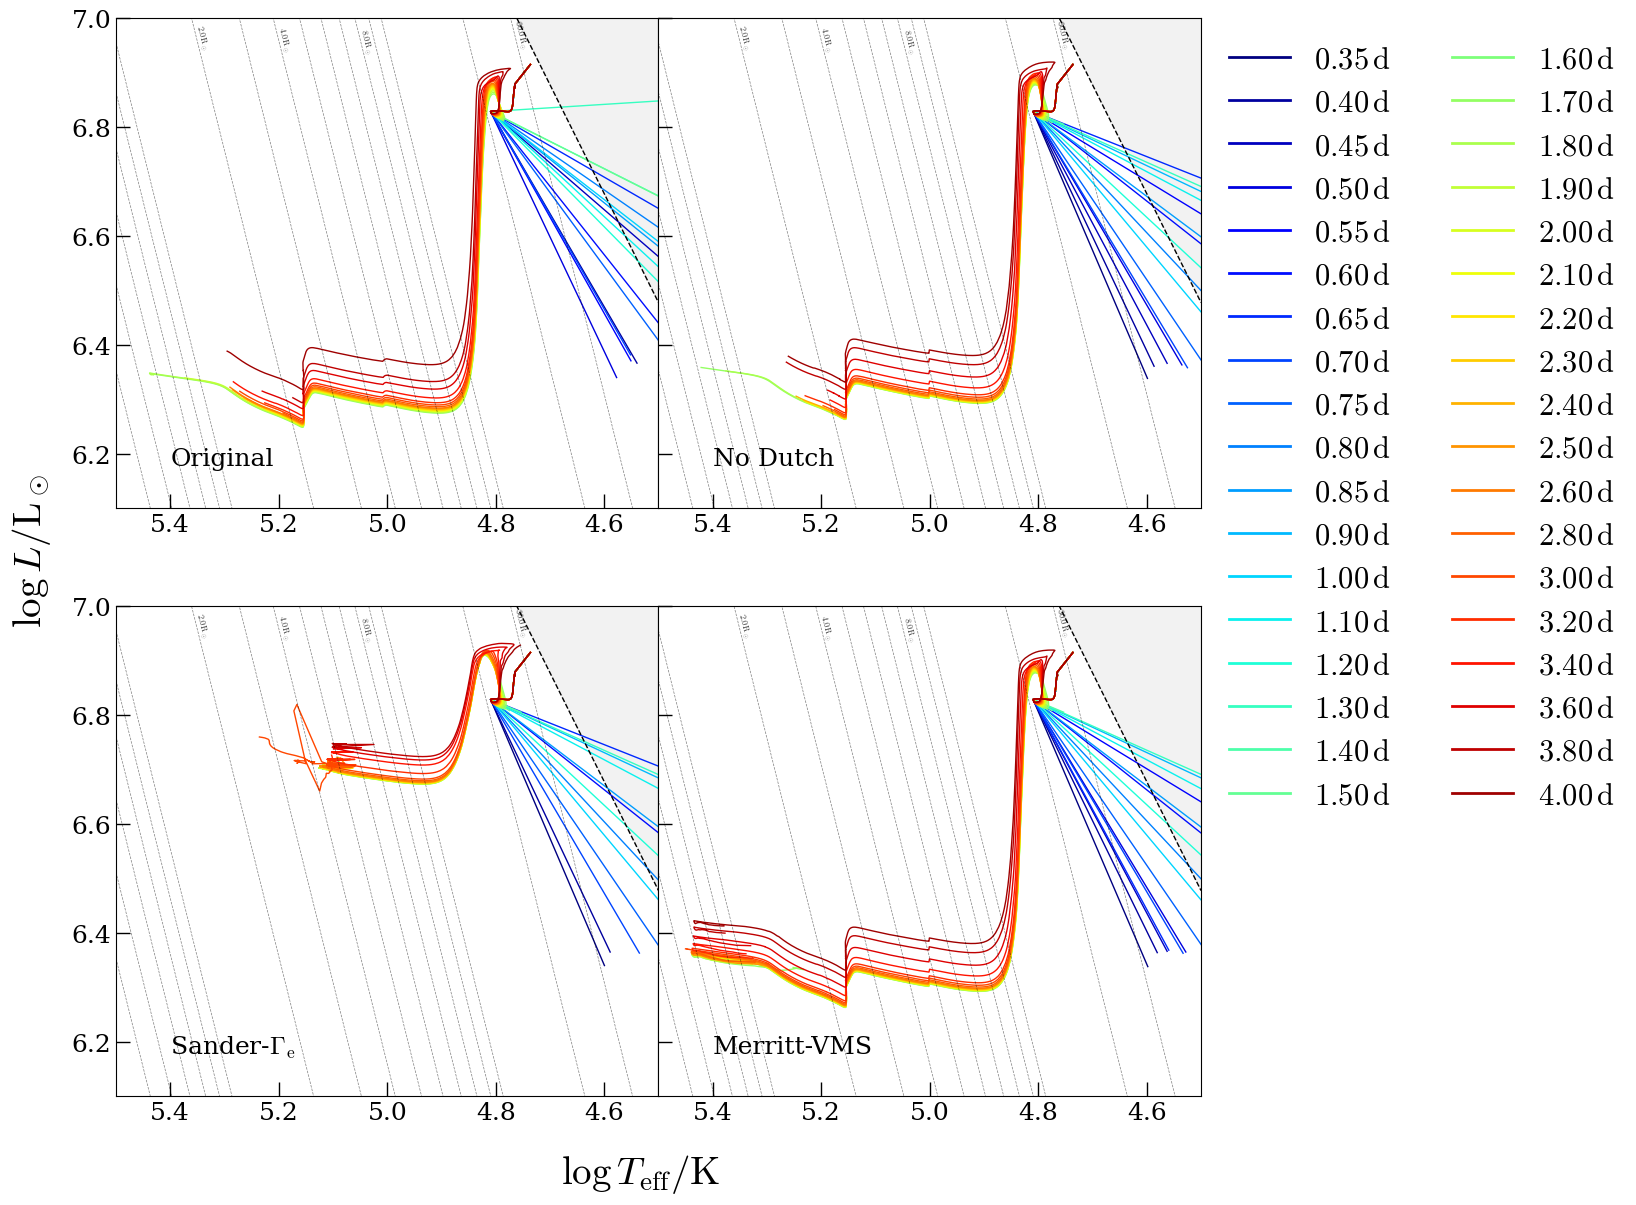

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey='row')
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

legend = False
labelx = False
labely = False

xlim = (5.5, 4.5)
ylim = (6.1, 7)

for i, (ax, label) in enumerate(zip(axes.flatten(), model_labels)):
    models_to_plot = [i]
    model_style_list = ['-']
       
    if i == 1:
        legend = True
    else:
        legend = False
               
    ax = hr_diagram_tracks(
        ax=ax,
        models_to_plot=models_to_plot,
        model_style_list=model_style_list,
        xlim=xlim,
        ylim=ylim,
        legend=legend,
        labelx=labelx,
        labely=labely
    )
    
    ax.tick_params(direction='in')
    ax.text(mass_label_x, mass_label_y, label, va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

savefig(fig, 'hr_allp_mass_comparison')


Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

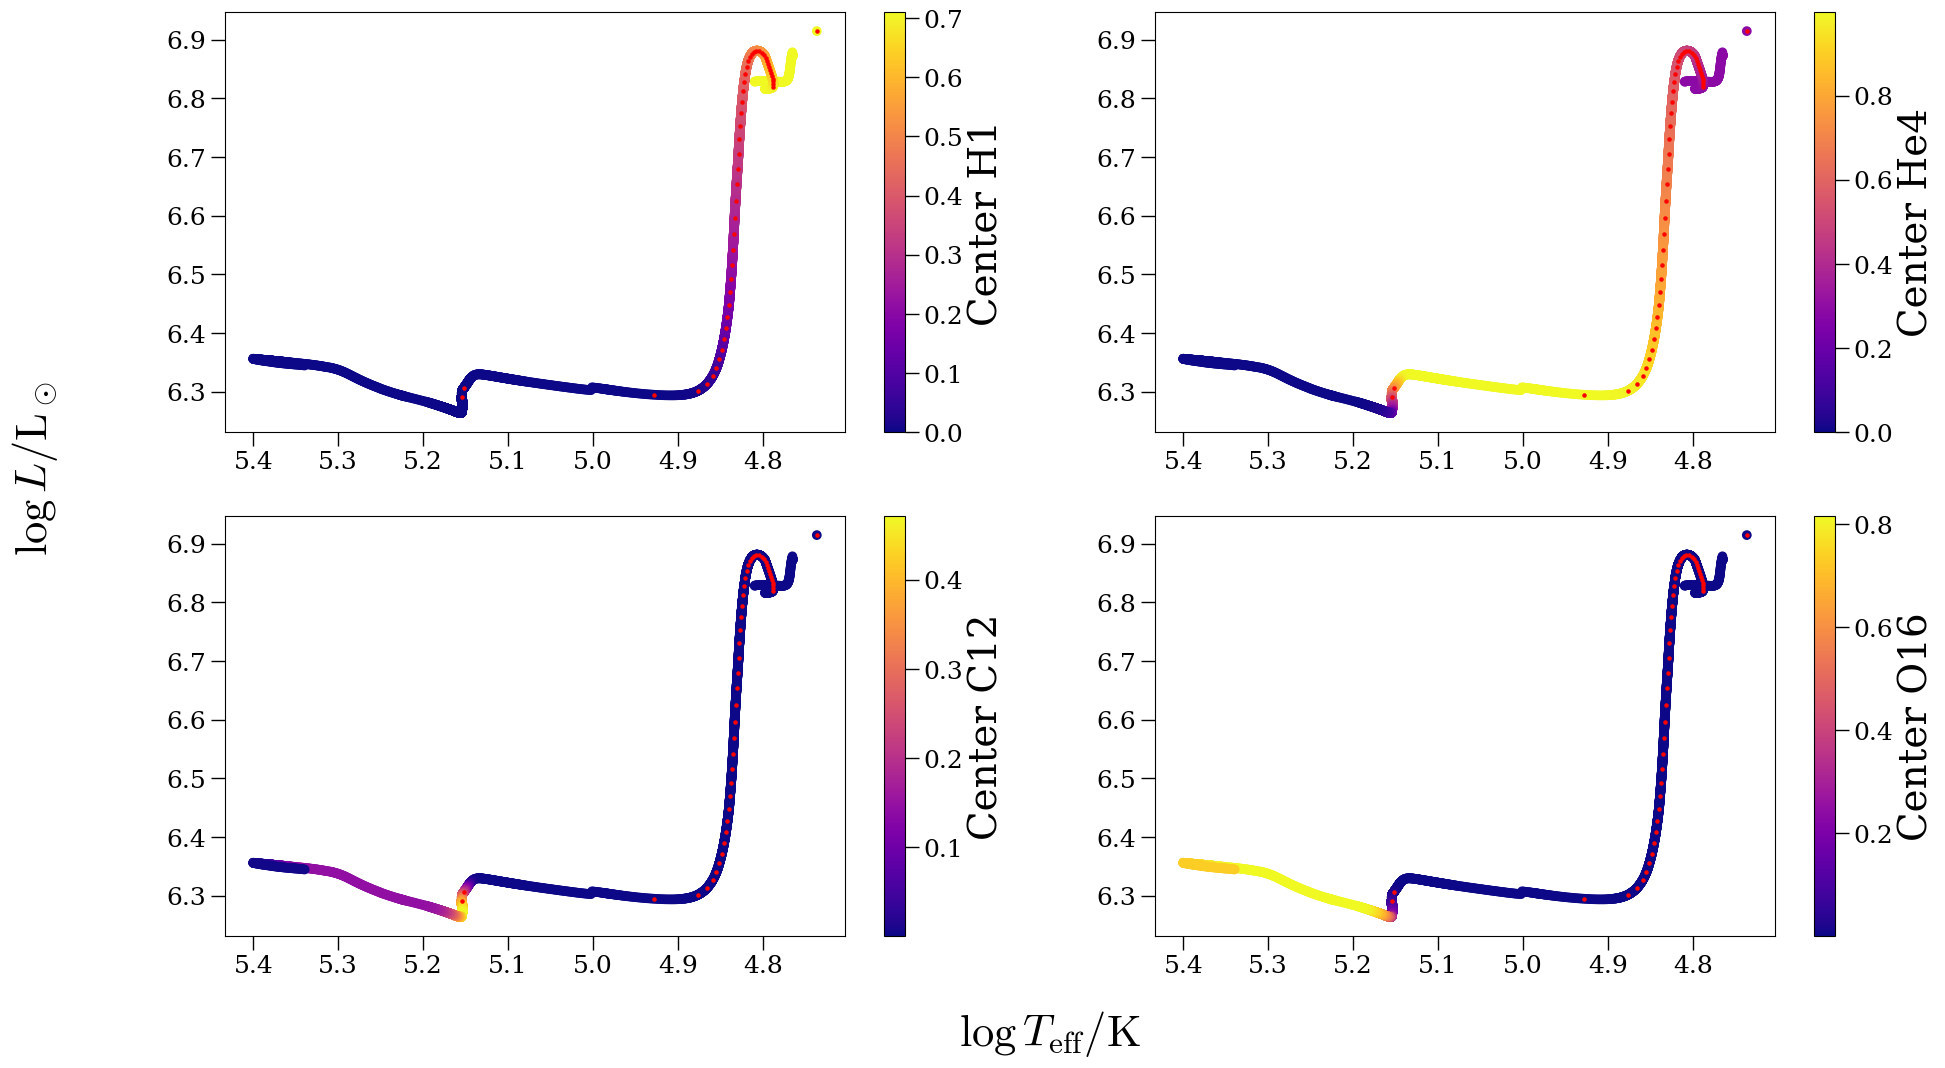

In [10]:
wind_test_h = mr.MesaData(str(model_dicts[3]['300.0']['2.00']/'LOGS/history.data'))

fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
models_to_mark = np.arange(0, 4000, 100)
models_to_mark = np.arange(0, 10**6.4, 5e4)
model_numbers = h.star_age
modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

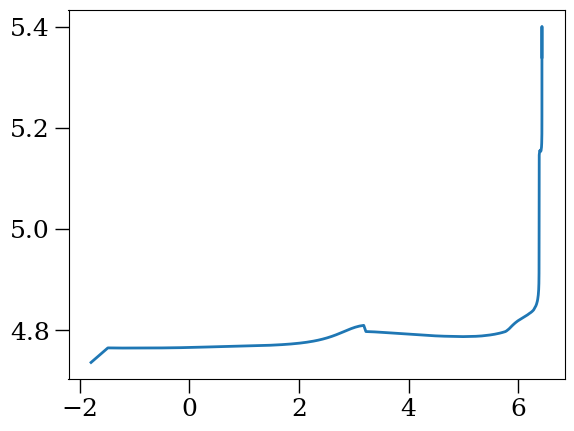

In [11]:
plt.plot(np.log10(h.star_age), h.log_Teff)

/mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg/004_m300_vms_merritt_switch/m3.000d+02_w3.636d-05/LOGS//profile41.data


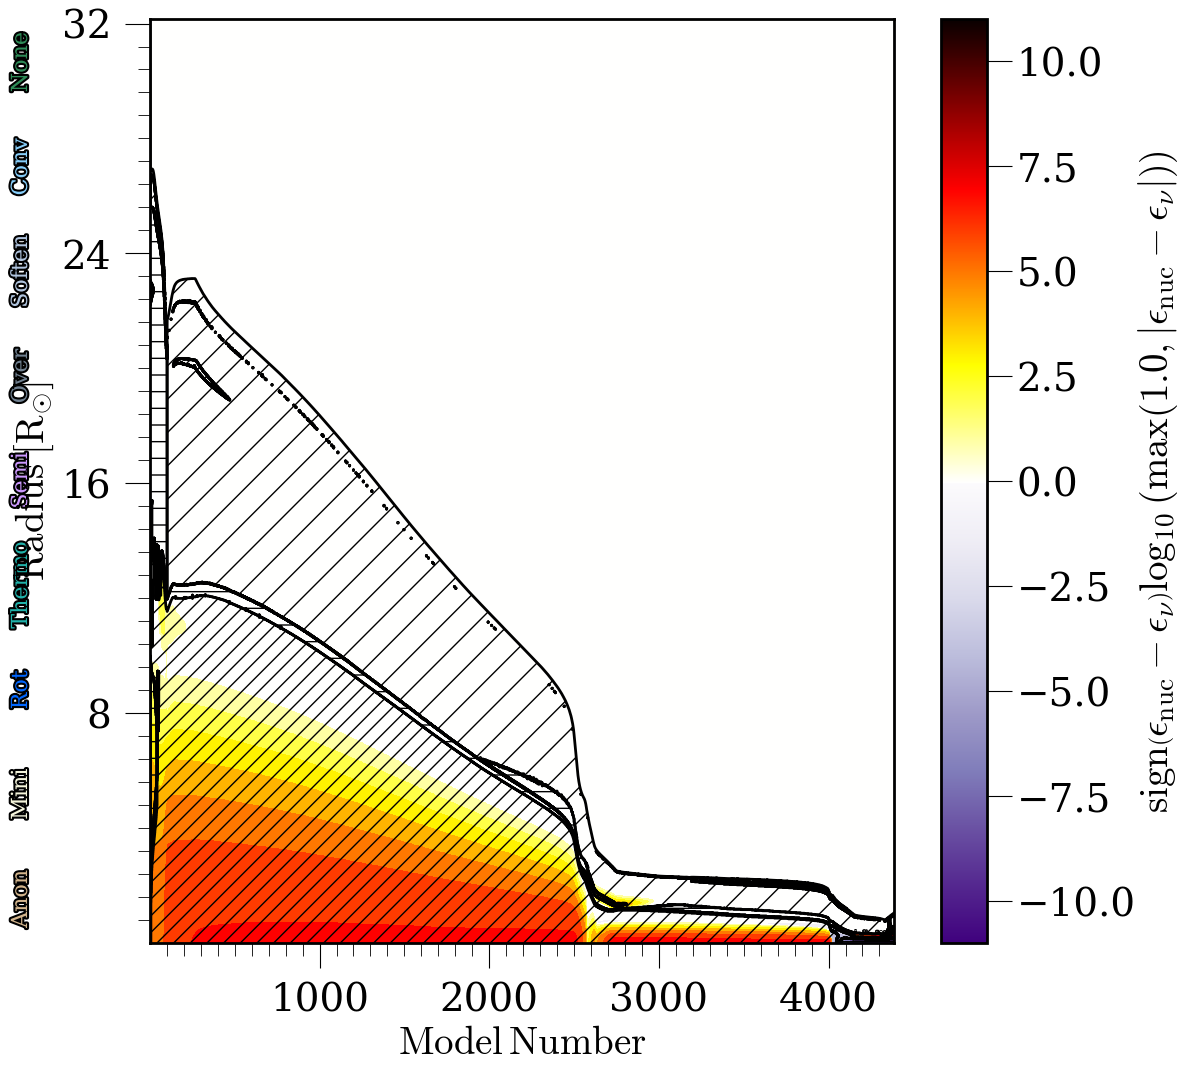

In [19]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[3]['300.0']['2.00']/'LOGS'))
mm.loadProfile(num=-4)
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, yaxis='radius', xaxis='model_number')
#p.plotKip3(mm,plot_type='profile',xaxis='model_number',yaxis='mass',zaxis='logRho',mod_min=1,mod_max=3000)
#p.plotAbun(mm)

/mnt/ceph/users/ldesa/mesa_che_grids/sse_test3_fiducial_dbg/004_m300_vms_merritt_switch/m3.000d+02_w3.636d-05/LOGS//profile41.data
2481.0


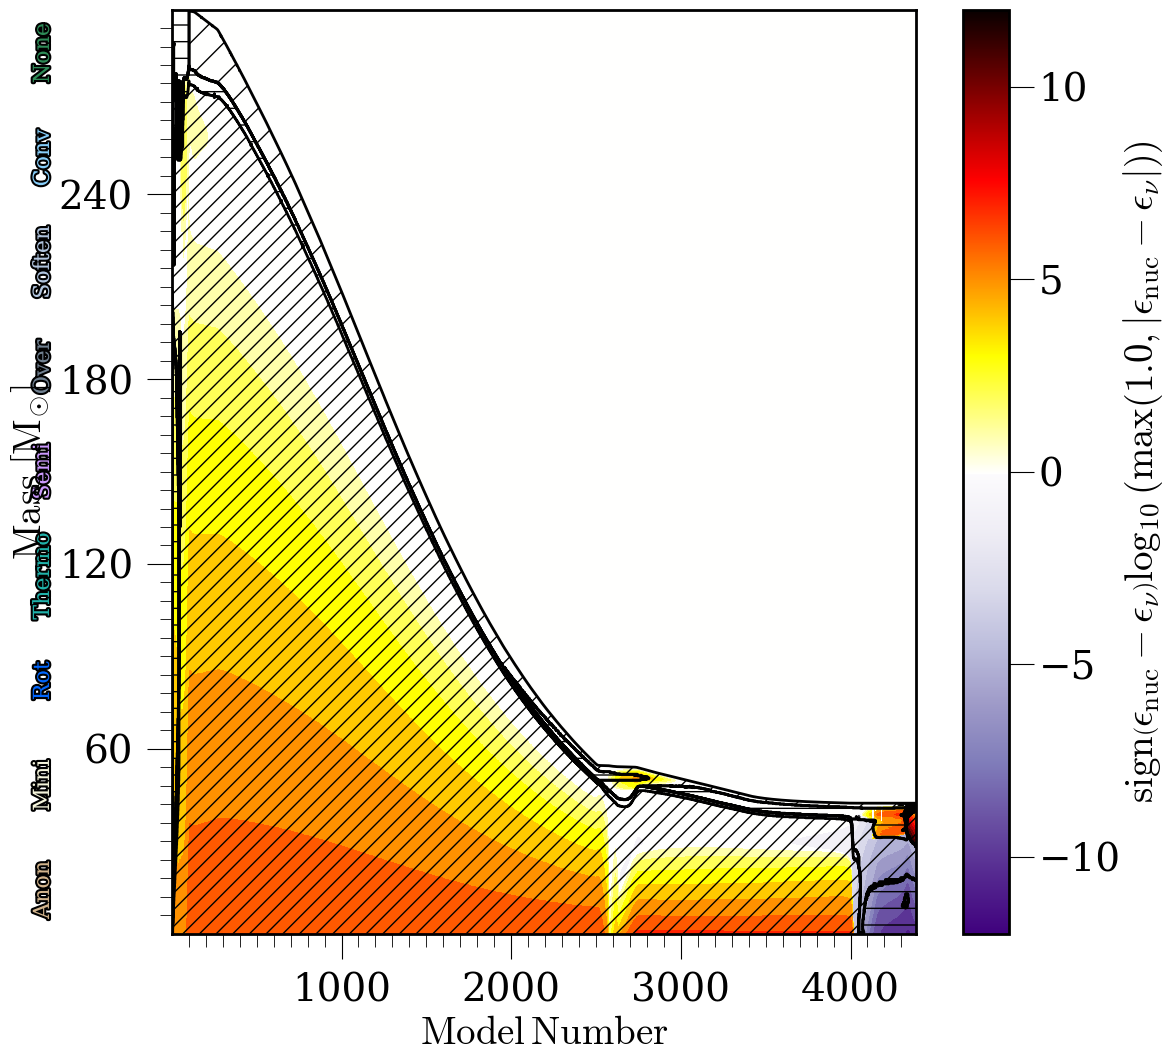

In [18]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[3]['300.0']['2.00']/'LOGS'))
mm.loadProfile(num=-4)
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, yaxis='mass', xaxis='model_number')
#p.plotKip3(mm,plot_type='profile',xaxis='model_number',yaxis='mass',zaxis='logRho',mod_min=1,mod_max=3000)
#p.plotAbun(mm)

Check the wind diagrams.

## Thin to thick winds transition in the Main Sequence

**Original**

In [12]:
wind_test_h = mr.MesaData(str(model_dicts[3]['300.0']['4.00']/'LOGS/history.data'))

wind_test_omega = wind_test_h.surf_avg_omega_div_omega_crit
wind_test_start_i = np.where(wind_test_omega > 0)[0][0]
wind_test_omega = wind_test_omega[wind_test_start_i:]

wind_test_l = 10.**wind_test_h.log_L[wind_test_start_i:]
wind_test_m = wind_test_h.star_mass[wind_test_start_i:]
wind_test_r = wind_test_h.radius[wind_test_start_i:]
wind_test_t = 10.**wind_test_h.log_Teff[wind_test_start_i:]
wind_test_z = np.tile([Z_SUN/10], len(wind_test_t))
#wind_test_x = np.tile([0.7], len(wind_test_t))
wind_test_x = wind_test_h.surface_h1[wind_test_start_i:]
wind_test_y = wind_test_h.surface_he4[wind_test_start_i:]
wind_test_model_n = wind_test_h.model_number[wind_test_start_i:]
wind_test_g = edd_gamma(wind_test_x, wind_test_l, wind_test_m)

wind_test_age = wind_test_h.star_age[wind_test_start_i:]

b21_winds = np.array([
    bjorklund2021_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
    ])
v01_winds = np.array([
    vink2001_w(l, m, t, z) for l, m, t, z in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z)
])
v11_winds = np.array([
    vink2011_w(l, m, z) for l, m, z in zip(wind_test_l, wind_test_m, wind_test_z)
])
v17_winds = np.array([
    vink2017_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
s23_winds = np.array([
    sander2023_w(l, m, t, z, x) for l, m, t, z, x in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x)
])
l_s23_winds = np.array([
    l_sander2023_w(l, t, z) for l, t, z in zip(wind_test_l, wind_test_t, wind_test_z)
])
k18_winds = np.array([
    krticka2018_w(l, z) for l, z in zip(wind_test_l, wind_test_z)
])
full_winds = np.array([
    winds(l, m, t, z, x, y, sander='g') for l, m, t, z, x, y in zip(wind_test_l, wind_test_m, wind_test_t, wind_test_z, wind_test_x, wind_test_y)
])

g_switch = np.array([
    sabhahit2023_switch_g(z) for z in wind_test_z
    ])

In [13]:
mesa_wind_rot = wind_test_h.log_abs_mdot[wind_test_start_i:]
try:
    mesa_wind = wind_test_h.log_abs_mdot_wind[wind_test_start_i:]
except AttributeError:
    print('No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost')
    mesa_wind = 10.**mesa_wind_rot
    mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    mesa_wind = np.log10(mesa_wind)
finally:
    unboosted_mesa_wind = 10.**mesa_wind_rot
    unboosted_mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
    unboosted_mesa_wind = np.log10(mesa_wind)
    

No log_abs_mdot_wind column, computing from log_abs_mdot and rotational_mdot_boost


/tmp/ipykernel_740838/1470942323.py:7: RuntimeWarning: divide by zero encountered in divide
  mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]
/tmp/ipykernel_740838/1470942323.py:11: RuntimeWarning: divide by zero encountered in divide
  unboosted_mesa_wind /= wind_test_h.rotational_mdot_boost[wind_test_start_i:]


/tmp/ipykernel_740838/1972855955.py:109: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0)


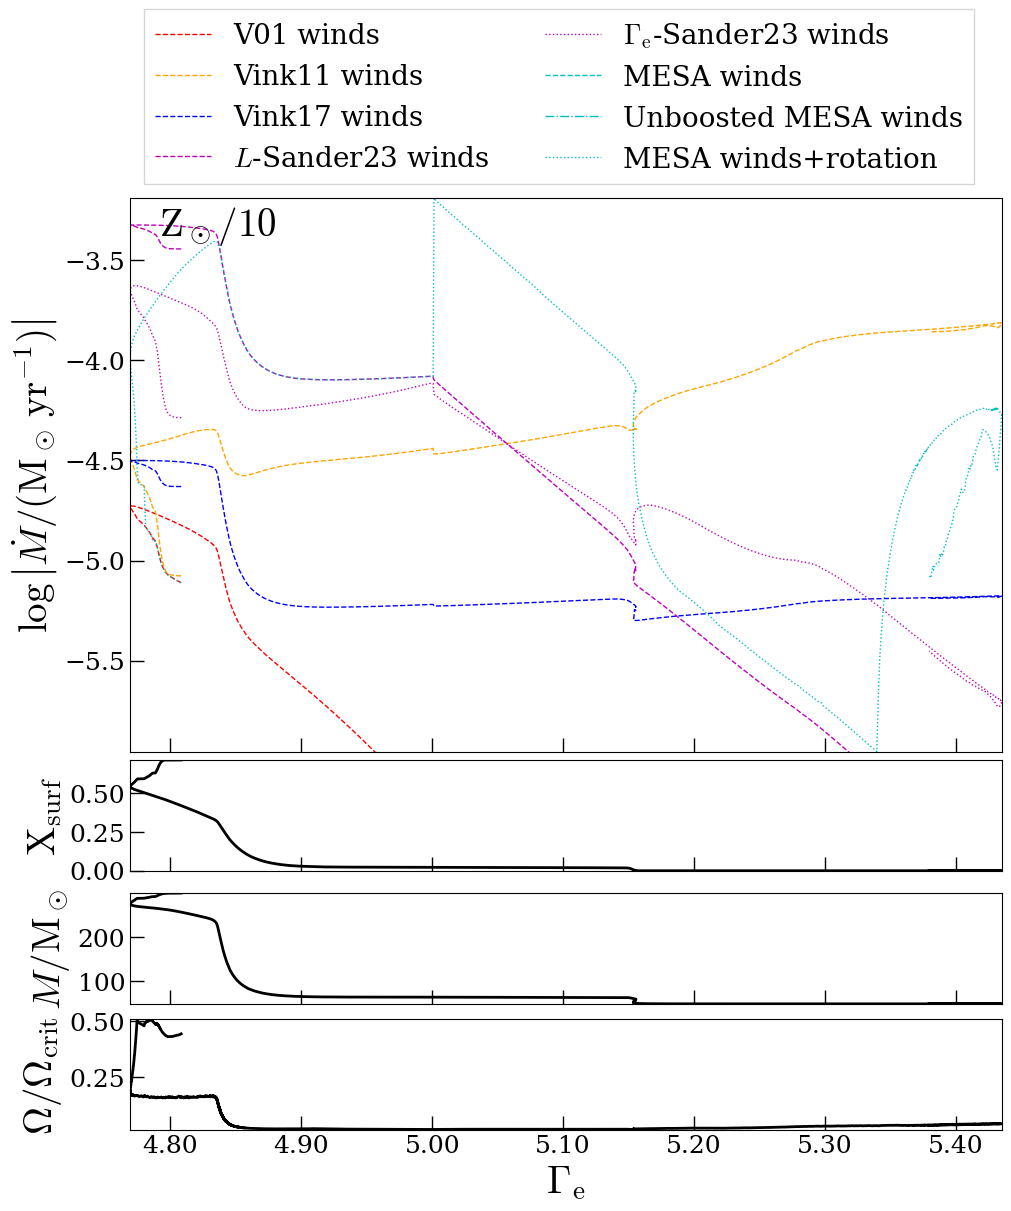

In [14]:
fig = plt.figure(figsize=(10, 12), layout='constrained')
gs = fig.add_gridspec(ncols=1, nrows=4, height_ratios=[1, 0.2, 0.2, 0.2], hspace=0)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[3,0])

x = np.log10(wind_test_t)
minx = min(x)
maxx = max(x)

#ax0.plot(x, np.log10(full_winds), 'k-', alpha=1, label='Full winds', lw=2)
ax0.plot(x, np.log10(v01_winds), 'r--', label='V01 winds', lw=1)
#ax0.plot(x, np.log10(k18_winds), 'g--', label='Krticka18 winds', lw=1)
ax0.plot(x, np.log10(v11_winds), '--', color='orange', label='Vink11 winds', lw=1)
ax0.plot(x, np.log10(v17_winds), 'b--', label='Vink17 winds', lw=1)
ax0.plot(x, np.log10(l_s23_winds), 'm--', label='$L$-Sander23 winds', lw=1)
ax0.plot(x, np.log10(s23_winds), 'm:', label='$\Gamma_\mathrm{e}$-Sander23 winds', lw=1)

#
miny = min(mesa_wind_rot)
maxy = max(mesa_wind_rot)

ax0.plot(x, mesa_wind, 'c--', label='MESA winds', lw=1)
ax0.plot(x, mesa_wind, 'c-.', label='Unboosted MESA winds', lw=1)
ax0.plot(x, mesa_wind_rot, 'c:', label='MESA winds+rotation', lw=1)

try: 
    y0_i = np.where(wind_test_h.surface_h1 <= 0.6)[0][0]
    y0_log_l = wind_test_h.log_L[y0_i]
except:
    y0_log_l = miny - 1
    
try:
    y1_i = np.where(wind_test_h.surface_h1 <= 0.3)[0][0]
    y1_log_l = wind_test_h.log_L[y1_i]
except:
    y1_log_l = maxy + 1
    
ax0.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax0.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
#ax0.text((y0_log_l+y1_log_l)/2, maxy-0.1, '$0.4<\\mathrm{Y}_\\mathrm{surf}<0.7$', ha='center', 
#         va='top', transform=ax0.transData, fontsize=16)

ax0.set_xlim(minx, maxx)
ax0.set_ylim(miny, maxy)
ax0.tick_params(direction='in')
ax0.set_xticklabels([])
ax0.set_ylabel('$\\log\\left|\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax0.legend(frameon=True, fancybox=False, ncol=2, loc='lower left', bbox_to_anchor=(0, 1),
           fontsize=20)
ax0.text(0.1, 0.95, '$\\mathrm{Z}_\\odot/10$', transform=ax0.transAxes, ha='center', va='center')

## Surface He4

y = wind_test_h.surface_h1[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax1.plot(x, y, color='k')

ax1.set_xticks(ax0.get_xticks())
ax1.set_xticklabels([])
ax1.set_xlim(ax0.get_xlim())

ax1.tick_params(direction='in')
ax1.set_ylabel('$\\mathrm{X}_\\mathrm{surf}$')

ax1.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax1.set_ylim(miny, maxy)

## Mass

y = wind_test_h.star_mass[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax2.plot(x, y, color='k')

ax2.set_xticks(ax0.get_xticks())
ax2.set_xticklabels([])
ax2.set_xlim(ax0.get_xlim())

ax2.tick_params(direction='in')
ax2.set_ylabel('$M/\\mathrm{M}_\\odot$')

ax2.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax2.set_ylim(miny, maxy)

# Surf avg omega/omega_crit

y = wind_test_h.surf_avg_omega_div_omega_crit[wind_test_start_i:]
miny = min(y)
maxy = max(y)
ax3.plot(x, y, color='k')

ax3.set_xticks(ax0.get_xticks())
ax3.set_xticklabels([f'{t:.2f}' for t in ax3.get_xticks()])
ax3.set_xlim(ax0.get_xlim())

ax3.tick_params(direction='in')
ax3.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax3.set_xlabel('$\\Gamma_\\mathrm{e}$')

ax3.vlines(y0_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.vlines(y1_log_l, miny, maxy, color='k', ls='-', lw=0.5)
ax3.set_ylim(miny, maxy)

fig.subplots_adjust(hspace=0)

#savefig(fig, 'windiag_m40_p060_zsun_div_10')

Why does the $L$-based prescription create stronger winds than the $\Gamma_\mathrm{e}$ one? We should first check the mismatch between the actual mass of the star and the mass assumed by the Sanders et al. (2020) models, as a function of luminosity.

In [15]:
def grafener_l_to_m_he_burning(l):
    """Relation 18 in Table A.1 of Gräfener et al. (2011)."""
    FF = [8.177, -1.0, 105.5, -10.10] # 18
    #FF = [3.997, -1.0, 25.83, -3.268] # 16
    #FF = [3.059, -1.0, 14.76, -2.049] # 17
    logm = FF[0] + FF[1] * np.sqrt(FF[2] + FF[3] * np.log10(l))
    return 10.**logm

def grafener_m_to_l_he_burning(m):
    """Relation 8 in Table A.1 of Gräfener et al. (2011)."""
    FF = [3.017, 2.446, -0.306] #6
    #FF = [3.017, 2.446, -0.306] # 7
    #FF = [3.826, 1.619, -0.099] # 8
    log_l = FF[0] + FF[1]*np.log10(m) + FF[2]*np.log10(m)**2
    return 10.**log_l

Text(0.5, 0, 'Surface He4')

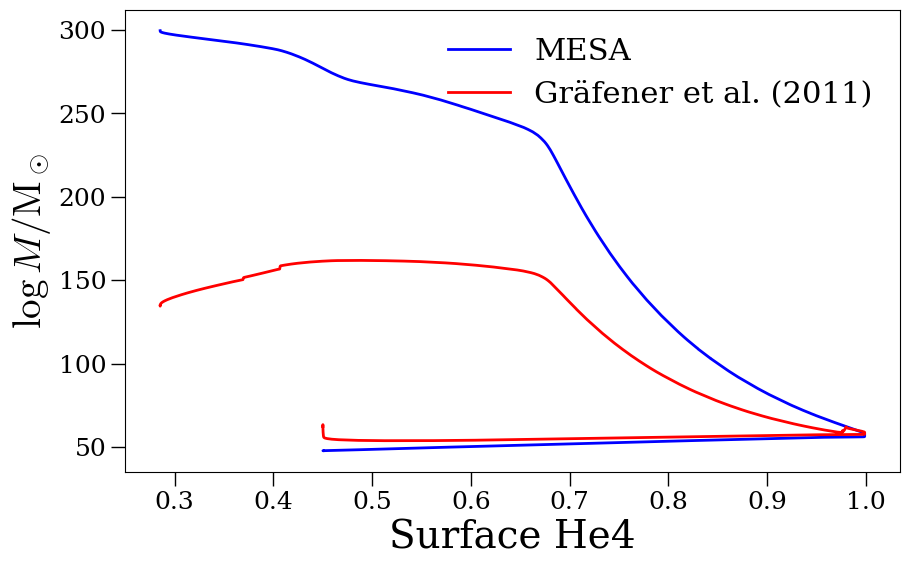

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

wind_test_grafener_m = grafener_l_to_m_he_burning(wind_test_l)

ax.plot(wind_test_y, wind_test_m, 'b-', label='MESA')
ax.plot(wind_test_y, wind_test_grafener_m, 'r-', label='Gräfener et al. (2011)')

ax.legend(frameon=False)
#ax.invert_xaxis()
ax.set_ylabel('$\log M/\mathrm{M}_\odot$')
ax.set_xlabel('Surface He4')

Text(0, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

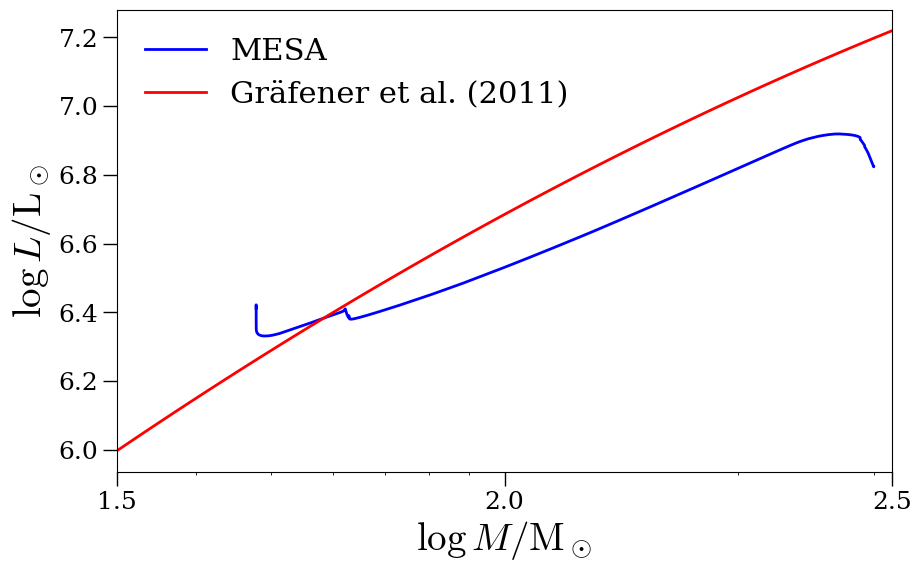

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

wind_test_grafener_l = grafener_m_to_l_he_burning(np.logspace(1.5, 2.5, 100))

ax.plot(wind_test_m, np.log10(wind_test_l), 'b-', label='MESA')
ax.plot(np.logspace(1.5, 2.5, 100), np.log10(wind_test_grafener_l),  'r-', label='Gräfener et al. (2011)')

ax.legend(frameon=False)
#ax.invert_xaxis()
ax.set_xscale('log')
ax.set_xticks([10, 10.**1.5, 100, 10.**2.5])
ax.set_xticklabels([f'{np.log10(x):.1f}' for x in ax.get_xticks()])
ax.set_xlim(10.**1.5, 10.**2.5)

ax.set_xlabel('$\log M/\mathrm{M}_\odot$')
ax.set_ylabel('$\log L/\mathrm{L}_\odot$')

Text(0, 0.5, '$\\log L/\\mathrm{L}_\\odot$')

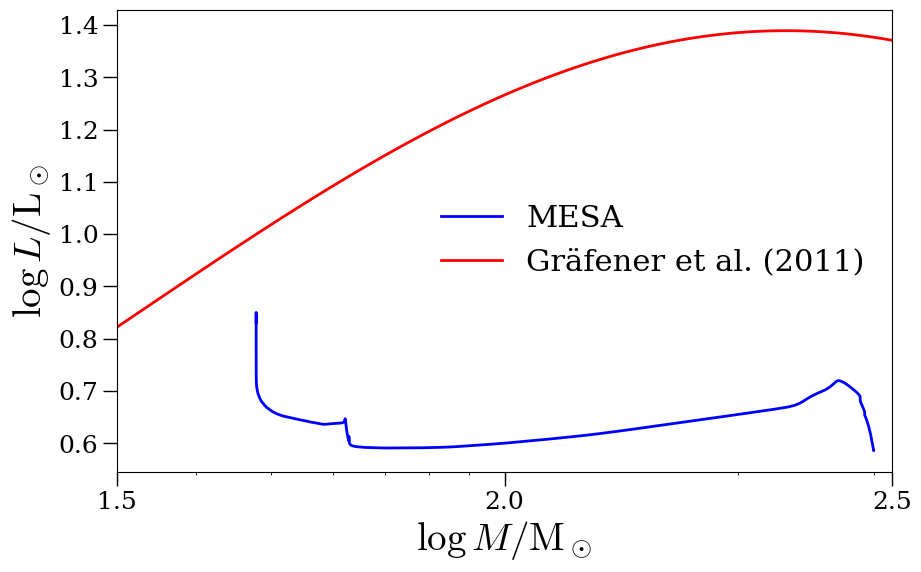

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

wind_test_grafener_l = grafener_m_to_l_he_burning(np.logspace(1.5, 2.5, 100))

ax.plot(wind_test_m, edd_gamma(wind_test_x, wind_test_l, wind_test_m), 'b-', label='MESA')
ax.plot(np.logspace(1.5, 2.5, 100), edd_gamma(np.tile([0.7], 100), wind_test_grafener_l, np.logspace(1.5, 2.5, 100)),  'r-', label='Gräfener et al. (2011)')

ax.legend(frameon=False)
#ax.invert_xaxis()
ax.set_xscale('log')
ax.set_xticks([10, 10.**1.5, 100, 10.**2.5])
ax.set_xticklabels([f'{np.log10(x):.1f}' for x in ax.get_xticks()])
ax.set_xlim(10.**1.5, 10.**2.5)

ax.set_xlabel('$\log M/\mathrm{M}_\odot$')
ax.set_ylabel('$\log L/\mathrm{L}_\odot$')

#### Merger rate comparison

In [18]:
h_original = mr.MesaData(str(model_dicts[0]['300.0']['2.00']/'LOGS/history.data'))
h_nodutch = mr.MesaData(str(model_dicts[1]['300.0']['2.00']/'LOGS/history.data'))
h_gsander = mr.MesaData(str(model_dicts[2]['300.0']['2.00']/'LOGS/history.data'))
h_vmsmerritt = mr.MesaData(str(model_dicts[3]['300.0']['2.00']/'LOGS/history.data'))

Text(0, 0.5, '$\\log|\\dot{M}|/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

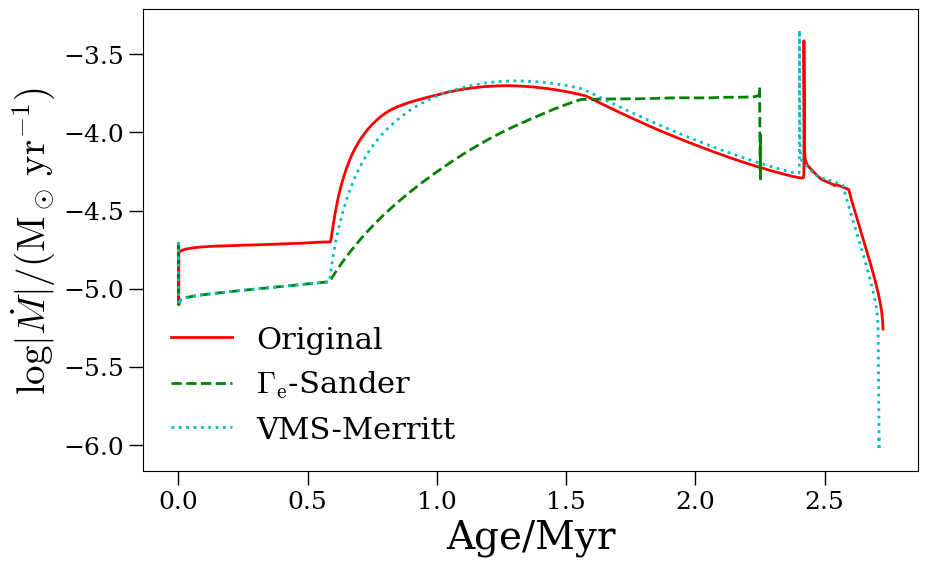

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

h = h_original
ax.plot(h.star_age/1e6, h.log_abs_mdot, 'r-', label='Original')

#h = h_nodutch
#ax.plot(h.star_age/1e6, h.log_abs_mdot, 'b-', label='No Dutch')

h = h_gsander
ax.plot(h.star_age/1e6, h.log_abs_mdot, 'g--', label='$\Gamma_\mathrm{e}$-Sander')

h = h_vmsmerritt
ax.plot(h.star_age/1e6, h.log_abs_mdot, 'c:', label='VMS-Merritt')

ax.legend(frameon=False)
ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\log|\dot{M}|/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')


Text(0, 0.5, '$M/\\mathrm{M}_\\odot$')

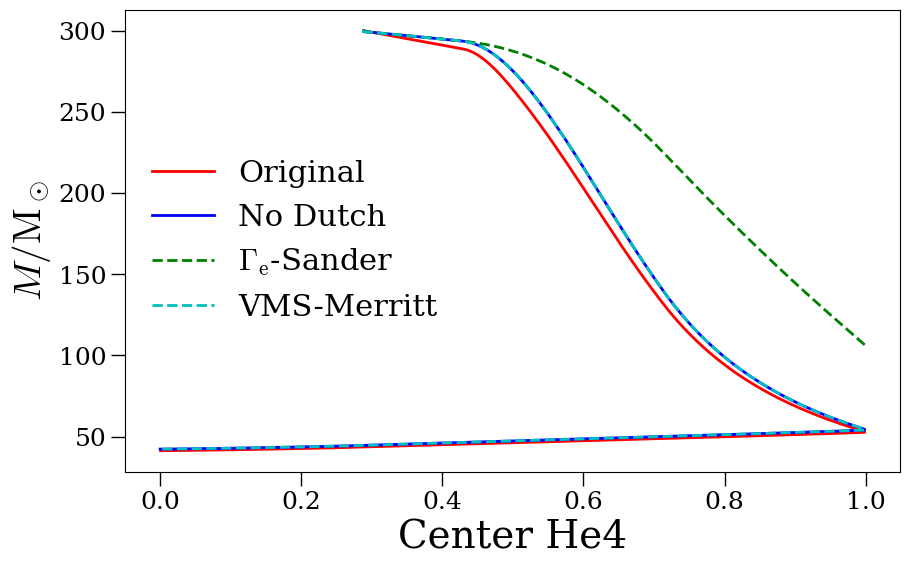

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
x = 'center_he4'
y = 'star_mass'

h = h_original
ax.plot(h.__getattr__(x), h.__getattr__(y), 'r-', label='Original')

h = h_nodutch
ax.plot(h.__getattr__(x), h.__getattr__(y), 'b-', label='No Dutch')

h = h_gsander
ax.plot(h.__getattr__(x), h.__getattr__(y), 'g--', label='$\Gamma_\mathrm{e}$-Sander')

h = h_vmsmerritt
ax.plot(h.__getattr__(x), h.__getattr__(y), 'c--', label='VMS-Merritt')

ax.legend(frameon=False)
ax.set_xlabel('Center He4')
ax.set_ylabel('$M/\mathrm{M}_\odot$')


Text(0, 0.5, '$M/\\mathrm{M}_\\odot$')

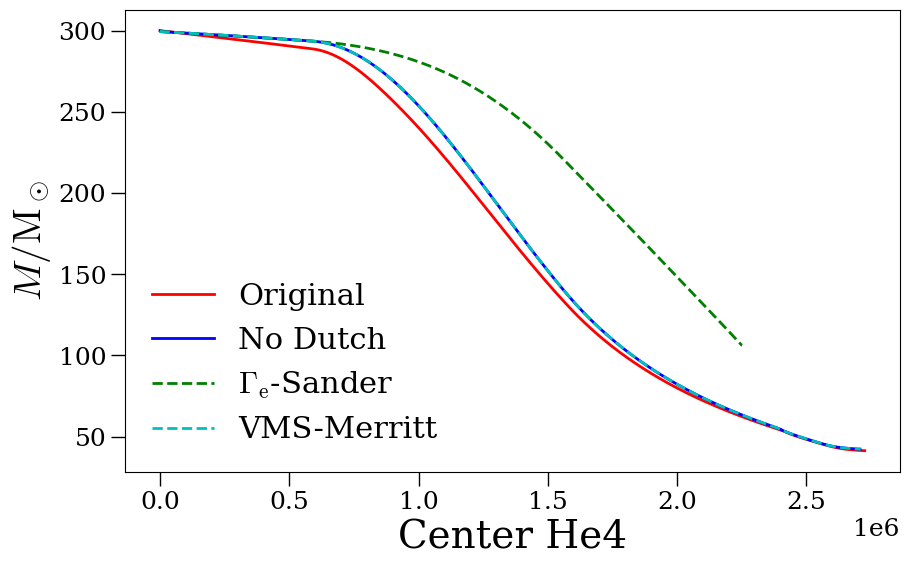

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
x = 'star_age'
y = 'star_mass'

h = h_original
ax.plot(h.__getattr__(x), h.__getattr__(y), 'r-', label='Original')

h = h_nodutch
ax.plot(h.__getattr__(x), h.__getattr__(y), 'b-', label='No Dutch')

h = h_gsander
ax.plot(h.__getattr__(x), h.__getattr__(y), 'g--', label='$\Gamma_\mathrm{e}$-Sander')

h = h_vmsmerritt
ax.plot(h.__getattr__(x), h.__getattr__(y), 'c--', label='VMS-Merritt')

ax.legend(frameon=False)
ax.set_xlabel('Center He4')
ax.set_ylabel('$M/\mathrm{M}_\odot$')


Text(0, 0.5, '$\\log|\\dot{M}|/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

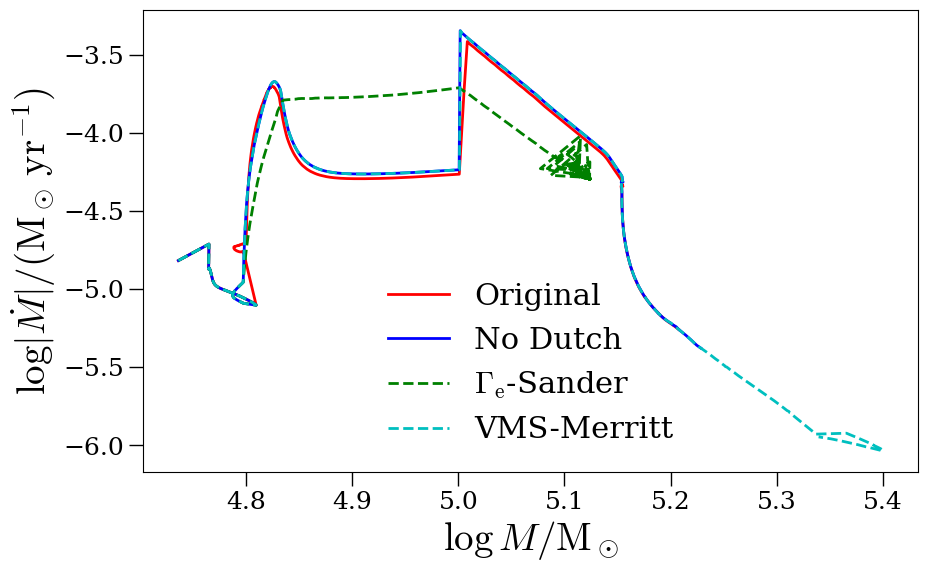

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
x = 'log_Teff'

h = h_original
ax.plot(h.__getattr__(x), h.log_abs_mdot, 'r-', label='Original')

h = h_nodutch
ax.plot(h.__getattr__(x), h.log_abs_mdot, 'b-', label='No Dutch')

h = h_gsander
ax.plot(h.__getattr__(x), h.log_abs_mdot, 'g--', label='$\Gamma_\mathrm{e}$-Sander')

h = h_vmsmerritt
ax.plot(h.__getattr__(x), h.log_abs_mdot, 'c--', label='VMS-Merritt')

ax.legend(frameon=False)
ax.set_xlabel('$\log M/\mathrm{M}_\odot$')
ax.set_ylabel('$\log|\dot{M}|/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})$')
